# Cardano Price Trend Prediction

In [1]:
# import of libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Model libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

In [3]:
#Metric Libraries
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

In [4]:
import warnings
warnings.filterwarnings("ignore")

**The dataset was extracted from investing.com**

The datasets were downloaded from www.investing.com and it contains the following features:

 - **Date:**	Daily date of the crypto information
 - **Price:**	USD prices of the crypto currency
 - **Open:**	Opening price of crypto currency (USD)
 - **High:**	Highest price of crypto currency (USD)
 - **Low:** 	Lowest price of crypto currency (USD)
 - **Vol.:**	Volume of crypto traded on the given date
 - **Change%:**	Percentage of the change in crypto currency prices relative to the previous day

In [5]:
cardano_hist = pd.read_csv('data/Cardano Historical Data.csv')

#columns to lower case
cardano_hist.columns = cardano_hist.columns.str.lower()

In [6]:
#Check  rows and columns
cardano_hist.head(5)

,date,price,open,high,low,vol.,change %
0,"Sep 30, 2021",2.1164,2.0655,2.1349,2.0515,250.07M,2.45
1,"Sep 29, 2021",2.0658,2.0370,2.1424,2.0220,272.69M,1.43
2,"Sep 28, 2021",2.0367,2.1312,2.1716,2.0300,289.31M,-4.41
3,"Sep 27, 2021",2.1307,2.2090,2.2726,2.1293,288.51M,-3.52
4,"Sep 26, 2021",2.2084,2.2985,2.2999,2.1490,452.94M,-3.92


In [7]:
cardano_hist.dtypes

date         object
price        object
open         object
high         object
low          object
vol.         object
change %    float64
dtype: object

In [8]:
print(cardano_hist.shape)

(1372, 7)


In [9]:
# Check for Nan values
cardano_hist.isna().sum()

date        2
price       1
open        1
high        1
low         1
vol.        1
change %    2
dtype: int64

* Out of 1372 rows, a few has nan values, later we will take a closer look to correct this values
* Most of the features were imported as a string value, an some of them have charaters that need to be transformed

## Data Cleansing

In [10]:
cardano_hist[cardano_hist["date"].isna()]

,date,price,open,high,low,vol.,change %
1370,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1371,NaN,Highest:3.0989,Lowest:0.0178,Difference:3.0812,Average:0.3722,Change %:258.7039,NaN


In [11]:
cardano_hist.tail(5)

,date,price,open,high,low,vol.,change %
1367,"Jan 02, 2018",0.7620,0.7022,0.8000,0.6750,10.97M,8.52
1368,"Jan 01, 2018",0.7022,0.7100,0.7150,0.6320,17.95M,-1.10
1369,"Dec 31, 2017",0.7100,0.5900,0.7400,0.5900,17.22M,20.34
1370,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1371,NaN,Highest:3.0989,Lowest:0.0178,Difference:3.0812,Average:0.3722,Change %:258.7039,NaN


The missing values correspond to thw last two rows.
* the first one has all missing values so we should delet this row
* the second one contains descriptive values that don't bellow to the information of the dataframe, so we should also drop this information 

In [12]:
# drop last two rows
cardano_hist = cardano_hist[:1370]

In [13]:
#change data type
for x in ['price','open','high','low']:
    cardano_hist[x] = cardano_hist[x].astype(float)

In [14]:
#change column name to make it more clear
cardano_hist = cardano_hist.rename(columns = {'change %':'change','vol.':'vol' })

In [15]:
#convert Date to datatime and create year, month and day column
cardano_hist.date = pd.to_datetime(cardano_hist.date)
cardano_hist[['year','month','day']] = cardano_hist.date.apply(lambda x: pd.Series(x.strftime("%Y-%m-%d").split("-")))
cardano_hist["month"] = cardano_hist["month"].astype(float)
cardano_hist["day"] = cardano_hist["day"].astype(float)

In [16]:

#delete % from string and transform to float
cardano_hist['change'] = cardano_hist.change.replace('%', '').astype(float)/100

**This fuction were inspired based on the open code from Kaggle: https://www.kaggle.com/jkreyner/script-to-clean-data-set**

In [17]:

def to_float(x):
    """
        Reformat column to numeric  
    Args: 
        x: Series of Vol to be transformed
    """    
    # transform to numeric base on the string value
    if type(x) == float or type(x) == int:
        return x
    if 'K' in x:
        if len(x) > 1:
            return float(x.replace('K', '')) * 1000
        return 1000.0
    if 'M' in x:
        if len(x) > 1:
            return float(x.replace('M', '')) * 1000000
        return 1000000.0
    if 'B' in x:
        return float(x.replace('B', '')) * 1000000000
    return

In [18]:
#transform data type to float
cardano_hist['vol'] = cardano_hist['vol'].apply(to_float)

In [19]:
# lets check for nan values after this transformations
print(cardano_hist.isna().sum())
cardano_hist[cardano_hist["vol"].isna()]

date      0
price     0
open      0
high      0
low       0
vol       5
change    0
year      0
month     0
day       0
dtype: int64


,date,price,open,high,low,vol,change,year,month,day
10,2021-09-20,2.0684,2.2827,2.2884,1.9827,NaN,-0.0939,2021,9.0,20.0
35,2021-08-26,2.5347,2.7402,2.7846,2.4701,NaN,-0.0750,2021,8.0,26.0
58,2021-08-03,1.3648,1.3086,1.3822,1.2626,NaN,0.0429,2021,8.0,3.0
80,2021-07-12,1.3147,1.3479,1.3731,1.2922,NaN,-0.0246,2021,7.0,12.0
259,2021-01-14,0.3110,0.3127,0.3241,0.2986,NaN,-0.0055,2021,1.0,14.0


This transformation creates some nan values, and checking in the original dataset it correspond to rows were the value were 0. That is, we had no information about the volumen traded this days, we could replace this nan with the volume of the previous day

In [20]:
cardano_hist.fillna(method='bfill', inplace = True)

In [21]:
print(cardano_hist.isna().sum())

date      0
price     0
open      0
high      0
low       0
vol       0
change    0
year      0
month     0
day       0
dtype: int64


In [22]:
#check that the nan was correctly remplaced
cardano_hist.iloc[8:12]

,date,price,open,high,low,vol,change,year,month,day
8,2021-09-22,2.2591,1.9842,2.2659,1.9691,564970000.0,0.1392,2021,9.0,22.0
9,2021-09-21,1.9830,2.0684,2.2239,1.9132,795400000.0,-0.0413,2021,9.0,21.0
10,2021-09-20,2.0684,2.2827,2.2884,1.9827,222620000.0,-0.0939,2021,9.0,20.0
11,2021-09-19,2.2827,2.3719,2.3959,2.2612,222620000.0,-0.0376,2021,9.0,19.0


In [23]:
cardano_hist.describe()

,price,open,high,low,vol,change,month,day
count,1370.000000,1370.000000,1370.000000,1370.000000,1.370000e+03,1370.000000,1370.000000,1370.000000
mean,0.372239,0.371315,0.390555,0.350343,4.592991e+08,0.002984,6.226277,15.733577
std,0.600406,0.598689,0.629400,0.566161,4.663479e+08,0.064444,3.351771,8.806074
min,0.023200,0.023200,0.026500,0.017800,4.810000e+06,-0.414900,1.000000,1.000000
25%,0.049800,0.049800,0.051700,0.048025,1.501675e+08,-0.030175,3.000000,8.000000
50%,0.093750,0.093750,0.097950,0.090600,3.282400e+08,0.000000,6.000000,16.000000
75%,0.296425,0.296425,0.313475,0.279025,5.962575e+08,0.030700,9.000000,23.000000
max,2.965200,2.965300,3.098900,2.903000,3.070000e+09,0.417300,12.000000,31.000000


In [24]:
# sort values in descending order
cardano_hist = cardano_hist.sort_values(by="date").reset_index(drop=True)

###  Target variable 

The target variables is not a feature included in our data set, so we need to create it.

Considering that our main objetive is predict the price tend for the next day our target is %change of the next day transformed to a binary variable where:
* 1: the prices increased the next day 
* 0: the prices decreased the next day (No price change is considered 0)

In [25]:
cardano_hist['future_increase'] = np.where(cardano_hist.change.shift(-1).fillna(value=0) > 0,1,0)

In [26]:
cardano_hist.head(10)

,date,price,open,high,low,vol,change,year,month,day,future_increase
0,2017-12-31,0.7100,0.5900,0.7400,0.5900,17220000.0,0.2034,2017,12.0,31.0,0
1,2018-01-01,0.7022,0.7100,0.7150,0.6320,17950000.0,-0.0110,2018,1.0,1.0,1
2,2018-01-02,0.7620,0.7022,0.8000,0.6750,10970000.0,0.0852,2018,1.0,2.0,1
3,2018-01-03,1.0800,0.9782,1.0900,0.8882,20230000.0,0.4173,2018,1.0,3.0,1
4,2018-01-04,1.1043,1.1000,1.3500,1.0500,19600000.0,0.0225,2018,1.0,4.0,0
5,2018-01-05,0.9949,1.1800,1.3000,0.9070,18530000.0,-0.0991,2018,1.0,5.0,1
6,2018-01-06,1.0358,1.0099,1.0830,0.9229,9120000.0,0.0411,2018,1.0,6.0,0
7,2018-01-07,1.0060,1.0200,1.0534,0.9800,4810000.0,-0.0288,2018,1.0,7.0,0
8,2018-01-08,0.9000,1.0130,1.0130,0.7520,10970000.0,-0.1054,2018,1.0,8.0,0
9,2018-01-09,0.8100,0.9000,0.9290,0.7729,7890000.0,-0.1000,2018,1.0,9.0,0


All features are ok, we are ready to explore the dataset

## Data Exploration

### Historical Price

First let's take a look at the cardano historical prices.

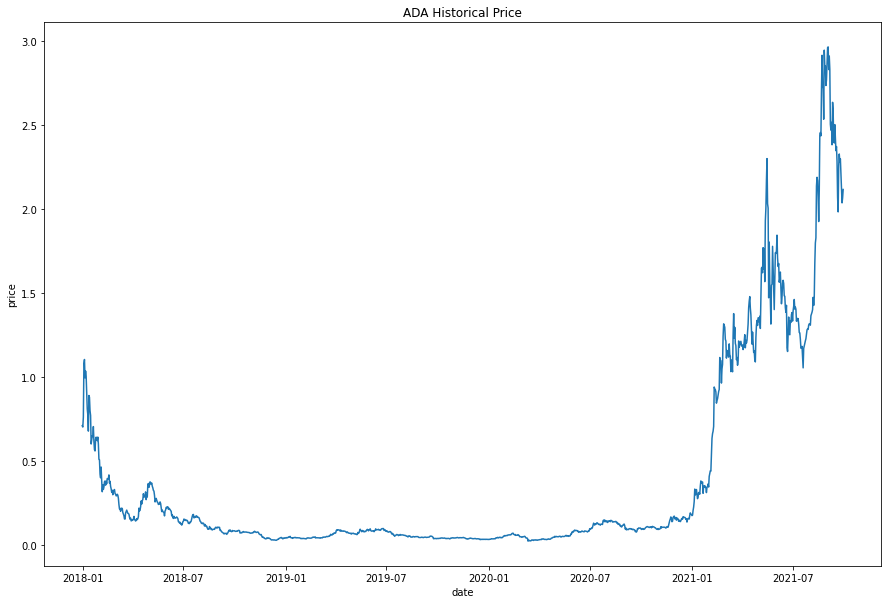

In [27]:
plt.figure(figsize=(15,10))
sns.lineplot(data=cardano_hist, x="date", y="price").set_title("ADA Historical Price");

It is important to see not only the increase in it price but how volatile cardano. Also it has had a lot up rallies and crashes during this period.
By visualization I can't no see any strange value, the graph seem prety smooth and continuos. But lets take a closer look to the Dataset

### Distribution of Features

### Distribution of the target variable

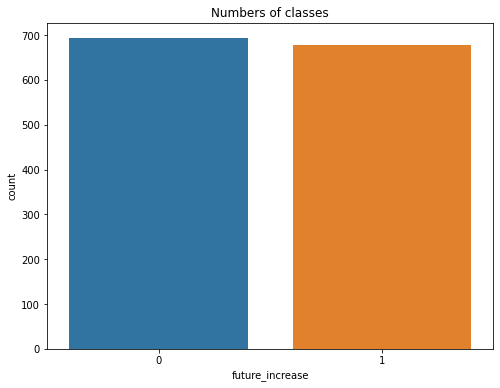

In [28]:

# groupby class to get counts
df_class = cardano_hist.groupby('future_increase')["date"].count().reset_index().rename(columns = {'date':'count'})
# plot the number of users that churned
plt.figure(figsize = [8,6])
ax = sns.barplot(data = df_class, x = 'future_increase', y='count')
plt.title("Numbers of classes");

We have a pretty balanced data set! that is really good for classification porpouses!

Let's take a look to the other variables:

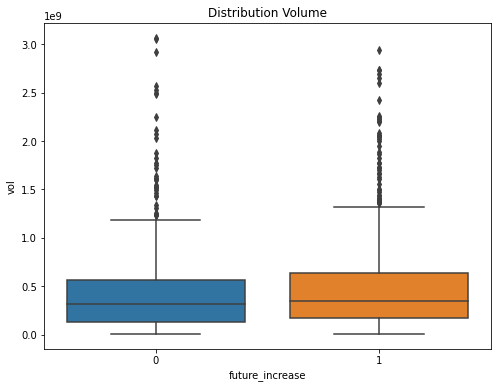

In [29]:
#plot boxplot
plt.figure(figsize = [8,6])
ax = sns.boxplot(data = cardano_hist, x = 'future_increase', y='vol')
plt.title("Distribution Volume");

It seems that volumen is a little bit higher when the prices increase, however the distribution is prety similar.

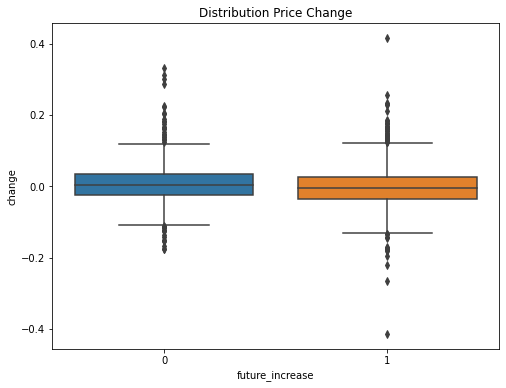

In [30]:
#plot boxplot
plt.figure(figsize = [8,6])
ax = sns.boxplot(data = cardano_hist, x = 'future_increase', y='change')
plt.title("Distribution Price Change");

Those distributions are also very similar but we can see that the distribution of "Future Increases" has lower values. This is really interesting, it seems that daily crashes are followed by price increases.

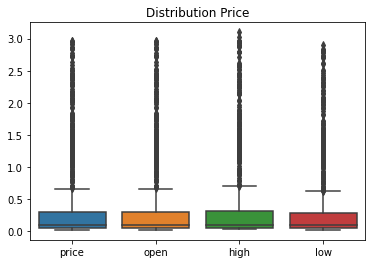

In [31]:
sns.boxplot(data=cardano_hist[['price', 'open', 'high', 'low']]).set_title("Distribution Price");

Price has a wide distribution because price has exponentially increased since 2017. This is important to consider cause the values in first years is different compared to recent years. Thus, we must be carefull if we use those variables. 

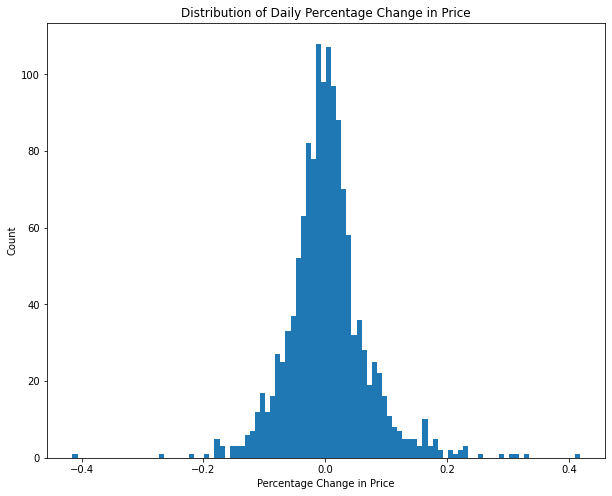

In [32]:
plt.figure(figsize=(10,8))
plt.hist(cardano_hist["change"].astype(float), bins = 100)
plt.title("Distribution of Daily Percentage Change in Price")
plt.xlabel("Percentage Change in Price")
plt.ylabel("Count");

The distribution of changes is prety symertical around 0

### Monthy return

In [33]:
cardano_hist["return"] = cardano_hist["change"] + 1
cardano_hist_month = cardano_hist.groupby(["year","month"])["return"].prod().reset_index()
cardano_hist_month["change"] = cardano_hist_month["return"] - 1

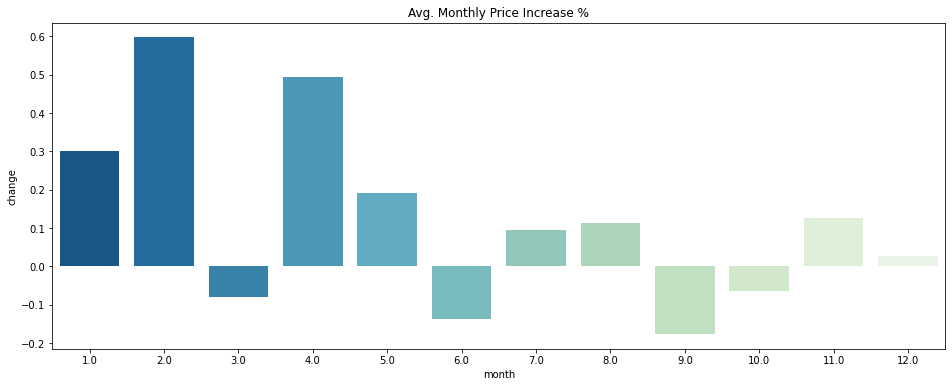

In [34]:
plt.figure(figsize=(16, 6))
ax = sns.barplot(x="month", y="change", data=cardano_hist_month.groupby("month")["change"].mean().reset_index()
                 ,palette="GnBu_r").set_title("Avg. Monthly Price Increase %")

## Feature Engineering

As the original dataset only have a few features it is important to build some aditional columns with information about trends, past history and performance. In this project I built the followings variables:

In [35]:
# Convert volumn to 10E9 for simplification
cardano_hist["vol"] = cardano_hist["vol"]/1000000000

In [36]:
# Exponential moving avergae at 30,50 and 200 days interval
cardano_hist['30d_ema_price'] = cardano_hist['price'].ewm(span=30, adjust=False).mean()
cardano_hist['50d_ema_price'] = cardano_hist['price'].ewm(span=50, adjust=False).mean()
cardano_hist['200d_ema_price'] = cardano_hist['price'].ewm(span=200, adjust=False).mean()

In [37]:
# Exponential moving avergae of the volumen at 30,50 and 200 days interval
cardano_hist['30d_ema_vol'] = cardano_hist['vol'].ewm(span=30, adjust=False).mean()
cardano_hist['50d_ema_vol'] = cardano_hist['vol'].ewm(span=50, adjust=False).mean()
cardano_hist['200d_ema_vol'] = cardano_hist['vol'].ewm(span=200, adjust=False).mean()

In [38]:
# Corresponding All time High value at the corresponding date
ath = [cardano_hist["high"][0]]
for i in cardano_hist["high"][1:]:
    if i > max(ath):
        ath.append(i)
    else:
        ath.append(max(ath))
        
cardano_hist["ath"] = ath

In [39]:
# Rolling minimung price at 30 dat interval
cardano_hist["30d_roll_low"] = cardano_hist["low"].rolling(30).min().fillna(cardano_hist["low"])

I am really concern that the nominal value at the beginning years is really small compare to recent year. Thus I will create some relative variable (ratios and relationship) to reduce this differences.

In [40]:
cardano_hist['30d_ema_price_ratio'] = cardano_hist['price']/cardano_hist['30d_ema_price']
cardano_hist['50d_ema_price_ratio'] = cardano_hist['price']/cardano_hist['50d_ema_price']
cardano_hist['200d_ema_price_ratio'] = cardano_hist['price']/cardano_hist['200d_ema_price']

cardano_hist['30d_ema_vol_ratio'] = cardano_hist['vol']/cardano_hist['30d_ema_price']
cardano_hist['50d_ema_vol_ratio'] = cardano_hist['vol']/cardano_hist['50d_ema_price']
cardano_hist['200d_ema_vol_ratio'] = cardano_hist['vol']/cardano_hist['200d_ema_price']

cardano_hist["ath_ratio"] = cardano_hist['price']/cardano_hist["ath"]

cardano_hist["30d_roll_low_ratio"] = cardano_hist['price']/cardano_hist["30d_roll_low"] 

### Test Train Split

In [41]:
train = cardano_hist[:max(cardano_hist[cardano_hist["date"]<"2021-05-01"].index)+1]
test = cardano_hist[max(cardano_hist[cardano_hist["date"]<"2021-05-01"].index)+1:]

In [42]:
train

,date,price,open,high,low,vol,change,year,month,day,...,ath,30d_roll_low,30d_ema_price_ratio,50d_ema_price_ratio,200d_ema_price_ratio,30d_ema_vol_ratio,50d_ema_vol_ratio,200d_ema_vol_ratio,ath_ratio,30d_roll_low_ratio
0,2017-12-31,0.7100,0.5900,0.7400,0.5900,0.01722,0.2034,2017,12.0,31.0,...,0.7400,0.5900,1.000000,1.000000,1.000000,0.024254,0.024254,0.024254,0.959459,1.203390
1,2018-01-01,0.7022,0.7100,0.7150,0.6320,0.01795,-0.0110,2018,1.0,1.0,...,0.7400,0.6320,0.989716,0.989440,0.989122,0.025300,0.025293,0.025284,0.948919,1.111076
2,2018-01-02,0.7620,0.7022,0.8000,0.6750,0.01097,0.0852,2018,1.0,2.0,...,0.8000,0.6750,1.068897,1.070608,1.072574,0.015388,0.015413,0.015441,0.952500,1.128889
3,2018-01-03,1.0800,0.9782,1.0900,0.8882,0.02023,0.4173,2018,1.0,3.0,...,1.0900,0.8882,1.466258,1.487221,1.512356,0.027465,0.027858,0.028329,0.990826,1.215942
4,2018-01-04,1.1043,1.1000,1.3500,1.0500,0.01960,0.0225,2018,1.0,4.0,...,1.3500,1.0500,1.452465,1.490254,1.538022,0.025780,0.026450,0.027298,0.818000,1.051714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1212,2021-04-26,1.2345,1.0901,1.2499,1.0820,0.71334,0.1327,2021,4.0,26.0,...,1.5566,0.9438,1.012856,1.054662,1.715623,0.585266,0.609423,0.991351,0.793075,1.308010
1213,2021-04-27,1.3079,1.2348,1.3326,1.2263,0.57944,0.0595,2021,4.0,27.0,...,1.5566,0.9438,1.068042,1.112250,1.802961,0.473176,0.492761,0.798767,0.840229,1.385781
1214,2021-04-28,1.3369,1.3075,1.3485,1.2350,0.57549,0.0221,2021,4.0,28.0,...,1.5566,0.9438,1.085301,1.130840,1.827609,0.467185,0.486788,0.786724,0.858859,1.416508
1215,2021-04-29,1.3070,1.3369,1.4103,1.2681,0.81753,-0.0224,2021,4.0,29.0,...,1.5566,0.9438,1.056867,1.100991,1.772856,0.661072,0.688671,1.108923,0.839651,1.384827


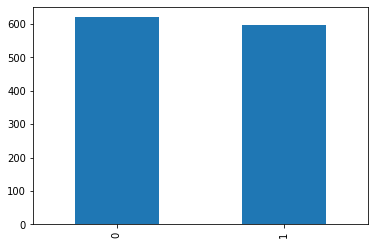

In [43]:
train['future_increase'].value_counts().plot(kind='bar');

The train dataset continues being balanced

In [44]:
test

,date,price,open,high,low,vol,change,year,month,day,...,ath,30d_roll_low,30d_ema_price_ratio,50d_ema_price_ratio,200d_ema_price_ratio,30d_ema_vol_ratio,50d_ema_vol_ratio,200d_ema_vol_ratio,ath_ratio,30d_roll_low_ratio
1217,2021-05-01,1.3518,1.3521,1.3676,1.3168,0.31778,-0.0002,2021,5.0,1.0,...,1.5566,0.9438,1.080517,1.126700,1.803841,0.254007,0.264864,0.424045,0.868431,1.432295
1218,2021-05-02,1.3266,1.3514,1.3546,1.2952,0.32532,-0.0187,2021,5.0,2.0,...,1.5566,0.9438,1.056260,1.101132,1.756751,0.259025,0.270029,0.430805,0.852242,1.405594
1219,2021-05-03,1.3622,1.3267,1.3799,1.3215,0.39015,0.0268,2021,5.0,3.0,...,1.5566,0.9438,1.078717,1.124917,1.789579,0.308957,0.322189,0.512556,0.875112,1.443314
1220,2021-05-04,1.2890,1.2793,1.3074,1.2757,0.58518,-0.0537,2021,5.0,4.0,...,1.5566,0.9438,1.019386,1.061783,1.681809,0.462781,0.482028,0.763508,0.828087,1.365755
1221,2021-05-05,1.4780,1.2900,1.4931,1.2900,0.78315,0.1466,2021,5.0,5.0,...,1.5566,0.9438,1.156258,1.207173,1.910754,0.612668,0.639646,1.012454,0.949505,1.566010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1365,2021-09-26,2.2084,2.2985,2.2999,2.1490,0.45294,-0.0392,2021,9.0,26.0,...,3.0989,1.9132,0.935243,0.969701,1.328414,0.191817,0.198884,0.272456,0.712640,1.154296
1366,2021-09-27,2.1307,2.2090,2.2726,2.1293,0.28851,-0.0352,2021,9.0,27.0,...,3.0989,1.9132,0.908059,0.937953,1.278093,0.122957,0.127005,0.173062,0.687567,1.113684
1367,2021-09-28,2.0367,2.1312,2.1716,2.0300,0.28931,-0.0441,2021,9.0,28.0,...,3.0989,1.9132,0.875454,0.900224,1.219018,0.124357,0.127875,0.173160,0.657233,1.064552
1368,2021-09-29,2.0658,2.0370,2.1424,2.0220,0.27269,0.0143,2021,9.0,29.0,...,3.0989,1.9132,0.894427,0.916210,1.233534,0.118066,0.120942,0.162829,0.666624,1.079762


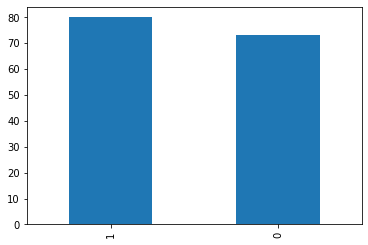

In [45]:
test['future_increase'].value_counts().plot(kind='bar');

The train dataset continues being balanced

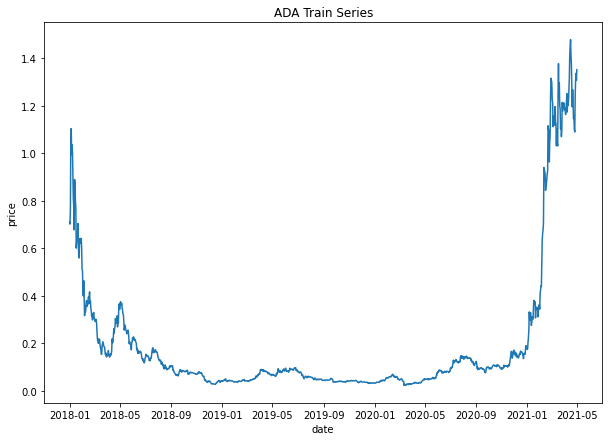

In [46]:
plt.figure(figsize=(10,7))
sns.lineplot(data=train, x="date", y="price").set_title("ADA Train Series");

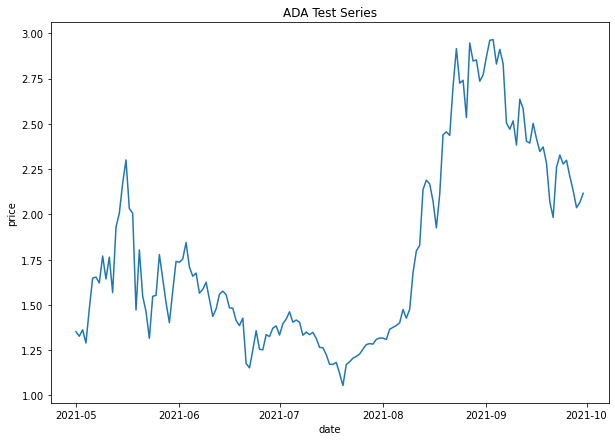

In [47]:
plt.figure(figsize=(10,7))
sns.lineplot(data=test, x="date", y="price").set_title("ADA Test Series");

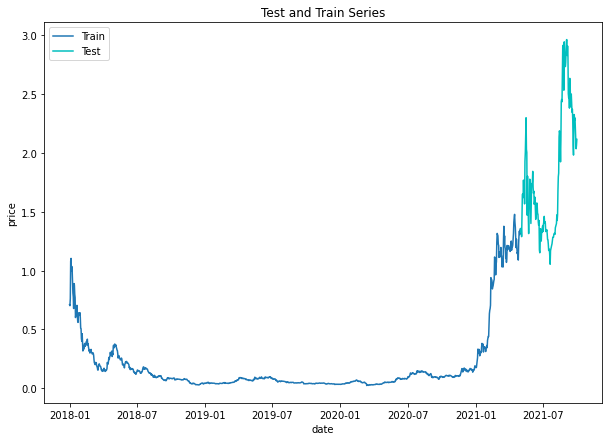

In [48]:
plt.figure(figsize=(10,7))
sns.lineplot(data=train, x="date", y="price", label="Train")
sns.lineplot(data=test, x="date", y="price", color='c', label="Test").set_title("Test and Train Series")
plt.show();

In [49]:
relative_features = ["change",'30d_ema_price_ratio','50d_ema_price_ratio','200d_ema_price_ratio','30d_ema_vol_ratio',
             '50d_ema_vol_ratio', '200d_ema_vol_ratio','ath_ratio','30d_roll_low_ratio']

#relative_features = ['price','vol','change','month','day']
X_train = train[relative_features]
y_train = train['future_increase']

X_test = test[relative_features]
y_test = test['future_increase']

## Modeling

Now we have created our features dataFrame with only numeric variables, we split the full dataset into train and test sets. We then tested out different machine learning classification algorithms, including:

### Logistic Regression

In [50]:
#class_weight = 'balanced'
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)
y_pred_train_lr = logreg.predict(X_train)

In [51]:
print("Accuracy Train:",logreg.score(X_train, y_train))
print("Accuracy Test:",logreg.score(X_test, y_test))

Accuracy Train: 0.5406737880032868
Accuracy Test: 0.47058823529411764


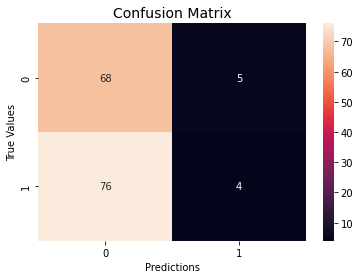

In [52]:
cmf = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cmf, annot=True).set(xlabel='Predictions', ylabel='True Values')
plt.title("Confusion Matrix", fontsize =14);

In [53]:
report = classification_report(y_test, y_pred_lr, output_dict=True)
report_lr = pd.DataFrame(report).transpose()
report_lr[["precision","recall","f1-score"]][:3]

,precision,recall,f1-score
0,0.472222,0.931507,0.626728
1,0.444444,0.050000,0.089888
accuracy,0.470588,0.470588,0.470588


In [54]:
proba_lr = logreg.predict_proba(X_test)
print("AUC Random Forest",roc_auc_score(y_test, proba_lr[:, 1]))

AUC Random Forest 0.4696917808219178


That was a bad model. Most of the prediction were classified as "0". 
Thus specificity is high but recall is low. Lets try another machine learning methods.

### Random Forest

In [55]:
rand_f = RandomForestClassifier()
#class_weight = 'balanced'
rand_f = rand_f.fit(X_train,y_train)

In [56]:
y_pred_rf = rand_f.predict(X_test)
y_pred__train_rf = rand_f.predict(X_train)

In [57]:
print("Accuracy Train:",accuracy_score(y_train, y_pred__train_rf))
print("Accuracy Test:",accuracy_score(y_test, y_pred_rf))

Accuracy Train: 1.0
Accuracy Test: 0.5294117647058824


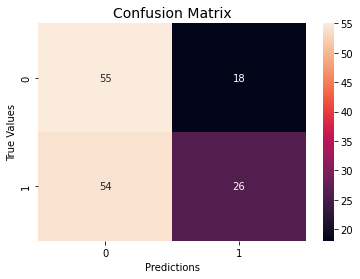

In [58]:
cmf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cmf, annot=True).set(xlabel='Predictions', ylabel='True Values')
plt.title("Confusion Matrix", fontsize =14);

In [59]:
report = classification_report(y_test, y_pred_rf, output_dict=True)
report_rf = pd.DataFrame(report).transpose()
report_rf[["precision","recall","f1-score"]]

,precision,recall,f1-score
0,0.504587,0.753425,0.604396
1,0.590909,0.325000,0.419355
accuracy,0.529412,0.529412,0.529412
macro avg,0.547748,0.539212,0.511875
weighted avg,0.549723,0.529412,0.507642


In [60]:
proba_rf = rand_f.predict_proba(X_test)
print("AUC Random Forest",roc_auc_score(y_test, proba_rf[:, 1]))

AUC Random Forest 0.5539383561643836


I obtained a model better than a logistic regression, however it has still pretty low accuracy and recall. Still most of the predictions are classified as "0"

### XGBoost Classifier

In [61]:
xgb_model = XGBClassifier(eval_metric='auc')
xgboost_m = xgb_model.fit(X_train, y_train)

In [62]:
y_pred_XG = xgboost_m.predict(X_test)
y_pred_train_XG = xgboost_m.predict(X_train)

In [63]:
print("Accuracy Train:",accuracy_score(y_train, y_pred_train_XG))
print("Accuracy Test:",accuracy_score(y_test, y_pred_XG))

Accuracy Train: 0.9983566146261298
Accuracy Test: 0.5490196078431373


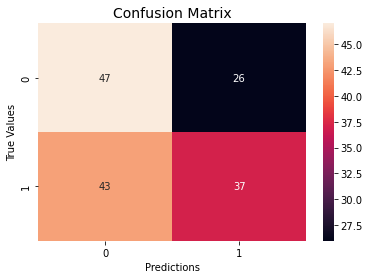

In [64]:
cmf = confusion_matrix(y_test, y_pred_XG)
sns.heatmap(cmf, annot=True).set(xlabel='Predictions', ylabel='True Values')
plt.title("Confusion Matrix", fontsize =14);

In [77]:
report = classification_report(y_test, y_pred_XG, output_dict=True)
report_xgm = pd.DataFrame(report).transpose()
report_xgm[["precision","recall","f1-score"]]

,precision,recall,f1-score
0,0.612245,0.410959,0.491803
1,0.586538,0.762500,0.663043
accuracy,0.594771,0.594771,0.594771
macro avg,0.599392,0.586729,0.577423
weighted avg,0.598804,0.594771,0.581341


In [78]:
proba_xg = xgboost_m.predict_proba(X_test)
print("AUC Xgboost",roc_auc_score(y_test, proba_xg[:, 1]))

AUC Xgboost 0.5751712328767122


The results were better than the previous models. However the metrics are still low. I will tune the parameters of the XGBoost to obtain the best model possible, however we can see that may be crptocurrency market prediction is a tough task due to its extreme volatility.

## Model Tuning

In [112]:
params = { 'max_depth': [3, 5, 6, 10],
           'learning_rate': [0.1,0.2, 0.5,1],
           'reg_lambda': [0,0.1,0.5,1,2,10],
           'n_estimators': [100, 300, 500],
         "gamma": [1,2,3]
         }

xgb_cl = xgb.XGBClassifier(objective="binary:logistic",eval_metric='auc')

random_search = RandomizedSearchCV(estimator=xgb_cl,
                         param_distributions=params,
                         scoring='accuracy',
                         n_iter=25,
                         verbose=1)

In [110]:
random_search.fit(X_train, y_train)
parameters = random_search.best_params_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


In [95]:
parameters

{'reg_lambda': 1,
 'n_estimators': 500,
 'max_depth': 10,
 'learning_rate': 1,
 'gamma': 3}

In [96]:
xgb_model = XGBClassifier(reg_lambda=1, n_estimators=500, max_depth=10, learning_rate=1,gamma = 3,objective="binary:logistic",eval_metric='auc')
xgboost_mrs = xgb_model.fit(X_train, y_train)

In [97]:
y_pred_XG = xgboost_mrs.predict(X_test)
y_pred_train_XG = xgboost_mrs.predict(X_train)

In [98]:
print("Accuracy Train:",accuracy_score(y_train, y_pred_train_XG))
print("Accuracy Test:",accuracy_score(y_test, y_pred_XG))

Accuracy Train: 0.9317995069843878
Accuracy Test: 0.5816993464052288


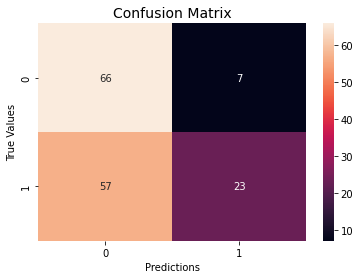

In [99]:
cmf = confusion_matrix(y_test, y_pred_XG)
sns.heatmap(cmf, annot=True).set(xlabel='Predictions', ylabel='True Values')
plt.title("Confusion Matrix", fontsize =14);

In [100]:
report = classification_report(y_test, y_pred_XG, output_dict=True)
report_xgmtun = pd.DataFrame(report).transpose()
report_xgmtun[["precision","recall","f1-score"]]

,precision,recall,f1-score
0,0.536585,0.904110,0.673469
1,0.766667,0.287500,0.418182
accuracy,0.581699,0.581699,0.581699
macro avg,0.651626,0.595805,0.545826
weighted avg,0.656889,0.581699,0.539986


In [101]:
proba_xg = xgboost_mrs.predict_proba(X_test)
print("AUC Xgboost Tuned",roc_auc_score(y_test, proba_xg[:, 1]))

AUC Xgboost Tuned 0.6023972602739727


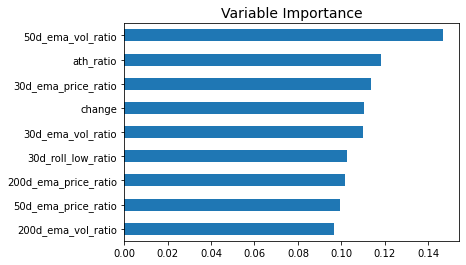

In [76]:
feat_importances = pd.Series(xgboost_mrs.feature_importances_, index=X_train.columns).sort_values(ascending = False)
feat_importances.plot(kind='barh').invert_yaxis()
plt.title("Variable Importance", fontsize =14);